## Waze : User Churn Classification Model

### Author: Khulekani Mgenge

In [2]:
#Import packages for data manipulation
import numpy as np
import pandas as pd

#Import packages for visualization
import matplotlib.pyplot as plt

#Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,\
ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# Import module to save our models once we fit them.
import pickle


In [3]:
# Load dataset
df = pd.read_csv('Waze_dataset.csv')

In [4]:
# Inspect first 5 rows
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
#Getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [6]:
# Creating a 'km_per_driving_day' feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Getting descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# Converting infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Confirming that values did convert
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [8]:
# Creating 'percentage_sessions_last_month' representing user's total sessions logged in
df['percentage_sessions_last_month'] = df['sessions'] / df['total_sessions']

# Getting descriptive stats.
df['percentage_sessions_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percentage_sessions_last_month, dtype: float64

In [9]:
# Creating 'professional_driver' feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [10]:
# Creating 'total_sessions_per_day' feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [11]:
#Getting descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [12]:
#Creating 'km_per_hour' feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [13]:
# Creating 'km_per_drive' feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [14]:
# Converting infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

#Confirming that values did convert
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [15]:
# Creating 'percentage_of_sessions_to_favorite' feature
df['percentage_of_sessions_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

#Get descriptive stats
df['percentage_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percentage_of_sessions_to_favorite, dtype: float64

In [16]:
#Drop rows with missing values
df = df.dropna(subset='label')

In [17]:
# Creating new 'device2' varaible
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [18]:
# Examine the class balance of the target varaible 'label'
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

In [19]:
#Convert 'label' column to binary
df['label'] = df['label'].map({'retained': 0, 'churned': 1})

In [20]:
# Drop 'ID' column
df = df.drop(['ID'],axis=1)

In [21]:
#Defining y(target) variable
y = df['label']

#Defining X(predictor) variable
X = df.drop(columns=['label', 'device'])

In [23]:
#Split data into 80/20 training and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42 )


In [24]:
#Split data 75/25 into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42) 

In [25]:
# Verify number of samples in the partition data
for x in [X_train,X_val,X_test]:
    print(len(x))

8579
2860
2860


In [26]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

In [27]:
#Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None], 'max_features': [1.0],
            'max_samples': [1.0], 'min_samples_leaf': [2],
            'min_samples_split': [2], 'n_estimators': [300],
            }

#Defining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}


In [28]:
#Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [29]:
%%time
rf_cv.fit(X_train,y_train)

CPU times: total: 4min 20s
Wall time: 4min 20s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'recall', 'precision', 'f1'})

In [30]:
#Examining best score across all the validation folds
rf_cv.best_score_

0.12678201409034398

In [31]:
#Examining best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [32]:
# Creating a helper function to output all scores of the model

def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name(string): which is the name of the model that will display in output table
        model_object: a GridSearchCV object that was fit
        metric (string): precision, recall, f1, accuracy
        
    Returns a pandas dataframe with F1, recall, precision, and accuracy scores for the model
    with the best mean metric score across all validation folds.
    '''
    
    #Creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                  }
    
    # Getting all the results from the CV and put them in a dataframe
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Isolating the row of the dataframe with max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    
    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # Creating a table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                         },
                        )
    
    return table
    


In [33]:
# Pass the GridSearchCV object to the 'make_results()' function
results = make_results('RandomForest', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RandomForest,0.457163,0.126782,0.198445,0.81851


In [34]:
# Instantiating the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

In [35]:
# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12], 'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1], 'n_estimators': [300]
            } 

# Deifining a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [36]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 4min 33s
Wall time: 1min 16s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'accuracy', 'recall', 'precision', 'f1'})

In [37]:
# Examining the best score
xgb_cv.best_score_

0.1708264263019754

In [38]:
# Examining the best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 300}

In [39]:
# Calling the 'make_results()' function on the GridSearchCV object
xgb_cv_results = make_results('XGBoost', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RandomForest,0.457163,0.126782,0.198445,0.818510
0,XGBoost,0.425932,0.170826,0.243736,0.811866


In [40]:
# Using the random forest to predict on the validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [41]:
#Creating a function to generate a table of score from the predictions on the validation data

def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.
    
    In:
       model_name (string): name of the model that will display in output table
       preds: numpy array of test predictions
       y_test_data: numpy array of the y_test_data
       
    Out:
       table: pandas dataframe for precision, recall, accuracy,and f1 scores for the model
    
    '''
    
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                         }
                        )
    
    return table


In [42]:
# Getting validation scores for Random Forest model
rf_val_scores = get_test_scores('Random Forest val', rf_val_preds, y_val)

# Append to the results Table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RandomForest,0.457163,0.126782,0.198445,0.818510
0,XGBoost,0.425932,0.170826,0.243736,0.811866
0,Random Forest val,0.445255,0.120316,0.189441,0.817483


In [43]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Getting validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGBoost val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RandomForest,0.457163,0.126782,0.198445,0.818510
0,XGBoost,0.425932,0.170826,0.243736,0.811866
0,Random Forest val,0.445255,0.120316,0.189441,0.817483
0,XGBoost val,0.422680,0.161736,0.233951,0.812238


In [44]:
# Using XGBoost model to predict on test data since it was clear champion
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Getting test scores for the XGBoost model
xgb_test_scores = get_test_scores('XGBoost test', xgb_test_preds,y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RandomForest,0.457163,0.126782,0.198445,0.818510
0,XGBoost,0.425932,0.170826,0.243736,0.811866
0,Random Forest val,0.445255,0.120316,0.189441,0.817483
0,XGBoost val,0.422680,0.161736,0.233951,0.812238
0,XGBoost test,0.423963,0.181460,0.254144,0.811189


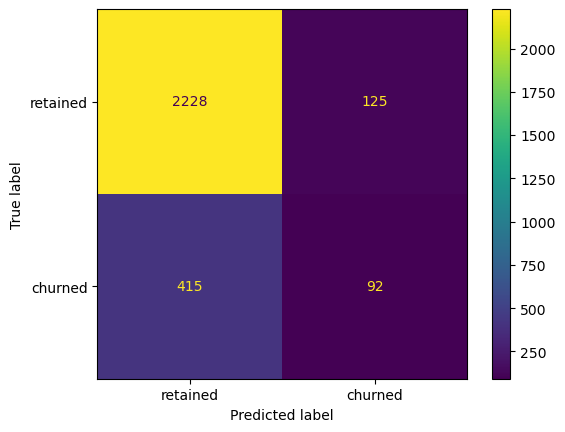

In [45]:
# Generating array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])

disp.plot();

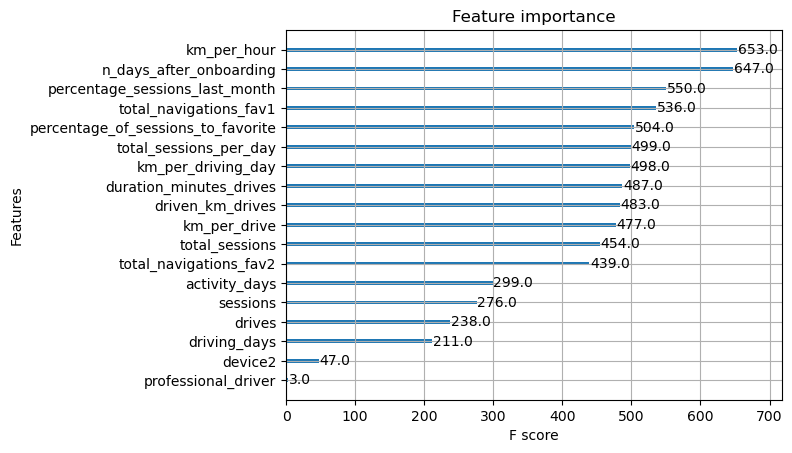

In [46]:
plot_importance(xgb_cv.best_estimator_);

### Conclusion

. The XGBoost model fit data better than random forest with a recall score of 0.173 while maintaining a similar accuracy     and precision score

. Validation scores of demonstrate that RF and XGBoost models did not overfit training data since its scores are slightly     decreasing compare to training scores. 

. The XGBoost is clear champion and will use it to predict on the test data.

. Confusion matrix shows that, the model predicted 3 times the false negatives than it did false positive and correctly 
  identifies roughly 18.2% of the user who actually churned.

. Engineered features accounted for six of the top 10 features and 3 of the top 5 feature.
